In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from model import Hand, Player, Game, Move

In [2]:
def draw(G, labels=None):
    plt.figure(1,figsize=(10, 20))
    G.graph.setdefault('graph', {})['rankdir'] = 'LR'
    # color nodes based on winner
    node_color = []
    for node in G.nodes(data=True):
        if node[1]['winner'] == 'player1':
            node_color.append('green')
        elif node[1]['winner'] == 'player2':
            node_color.append('red')
        else:
            node_color.append('lightgray')
    if labels:
        nx.draw_networkx(G, pos=graphviz_layout(G, prog='dot'), labels=nx.get_node_attributes(G, labels), node_color=node_color)
    else:
        nx.draw_networkx(G, pos=graphviz_layout(G, prog='dot'), node_color=node_color)
    plt.show()
    
def get_path(G, node_start, node_end, data=None, include_root=False):
    for child in G.predecessors(node_end):
        path = [G.nodes[node_end].get(data)]
        while child != node_start:
            path.insert(0, G.nodes[child].get(data))
            child = next(G.predecessors(child))

        if include_root:
            path.insert(0, G.nodes[node_start].get(data))
        return path

In [3]:
#####

In [4]:
#####

In [58]:
class AI:
    
    def __init__(self, game, max_depth=3):
        self.game = game
        self.max_depth = max_depth
    

    def eval_game_tree(self):
        """
        Run game simulations from current game state to a maximum number
        of moves ahead (max_depth)
        Return the graph of possible moves and outcomes, and the current (root) node
        """

        if self.max_depth < 1: return

        G = self.game.graph.copy()
        all_moves = ['ll','lr', 'rl', 'rr']
        root = self.game.turn-1
        n = root # node label which also serves as a node counter
        newleavelist=[]
        # First branch in look ahead
        #game.switch_players()
        for attack in all_moves:
            n=n+1

            # Add move node to graph
            G.add_node(n, attack=attack, winner=None, player=None)
            G.add_edge(root, n)
            attack_sequence = get_path(G, 0, n, 'attack', include_root=False)
            ## Gun game simulation:
            minigame = Game(Player(self.game.active.name), Player(self.game.inactive.name))
            is_legal = minigame.check_moves(attack_sequence)
            if not is_legal:
                G.remove_node(n)
                continue


            G.nodes[n]['player'] = minigame.inactive.name
            if minigame.winner:
                # print(minigame.winner, attack_sequence)
                # stop path when result
                G.nodes[n]['winner'] = minigame.winner
                continue

            newleavelist.append(n)


        depth=1

        # subsequent branches
        while depth < self.max_depth:
            leavelist = newleavelist[:]
            newleavelist = []
            for leave in leavelist:
                for attack in all_moves:
                    n=n+1
                    # Add move node to graph
                    G.add_node(n, attack=attack, winner=None, player=None)
                    G.add_edge(leave, n)
                    attack_sequence = get_path(G, 0, n, 'attack', include_root=False)
                    ## Gun game simulation:
                    minigame = Game(Player(self.game.active.name), Player(self.game.inactive.name))
                    is_legal = minigame.check_moves(attack_sequence)
                    if not is_legal:
                        G.remove_node(n)
                        continue

                    G.nodes[n]['player'] = minigame.inactive.name

                    if minigame.winner:
                        # print(minigame.winner, attack_sequence)
                        # stop path when result
                        G.nodes[n]['winner'] = minigame.winner
                        G.nodes[n]['attack'] = attack
                        continue
                        


                    newleavelist.append(n)
            depth=depth+1
        return G, root
    
    @staticmethod
    def minimax(G, n):
        """Perform minimax from node n on a NetworkX graph G.
        Assume node n is a maximiser node.
        Return node corresponding to best move
        """

        maxplayer = True
        minplayer = False
        def _minimax(G, n, player):

            # Base case, winning node found
            if G.nodes[n]["winner"]:
                score = {'player1': 1, 'player2': -1}.get(G.nodes[n]['winner'])
                G.nodes[n].update({'score': score})
                return score

            if player == maxplayer:
                bestv = -1
                for child in G.successors(n):
                    v = _minimax(G, child, minplayer)
                    G.nodes[child].update({'score': v})
                    bestv = max(bestv, v)
            else:
                bestv = 1
                for child in G.successors(n):
                    v = _minimax(G, child, maxplayer)
                    G.nodes[child].update({'score': v})
                    bestv = min(bestv, v)
            return bestv

        # Find the best first move from the given node
        # Assume given node n is a maximiser node.
        best_move = None
        bestv = -1

        for child in G.successors(n):
            v = _minimax(G, child, minplayer)
            G.nodes[child].update({'score': v})

            if v > bestv:
                best_move = child
                bestv = v
        return best_move

player1 ['ll', 'lr', 'rl', 'rr', 'rr']


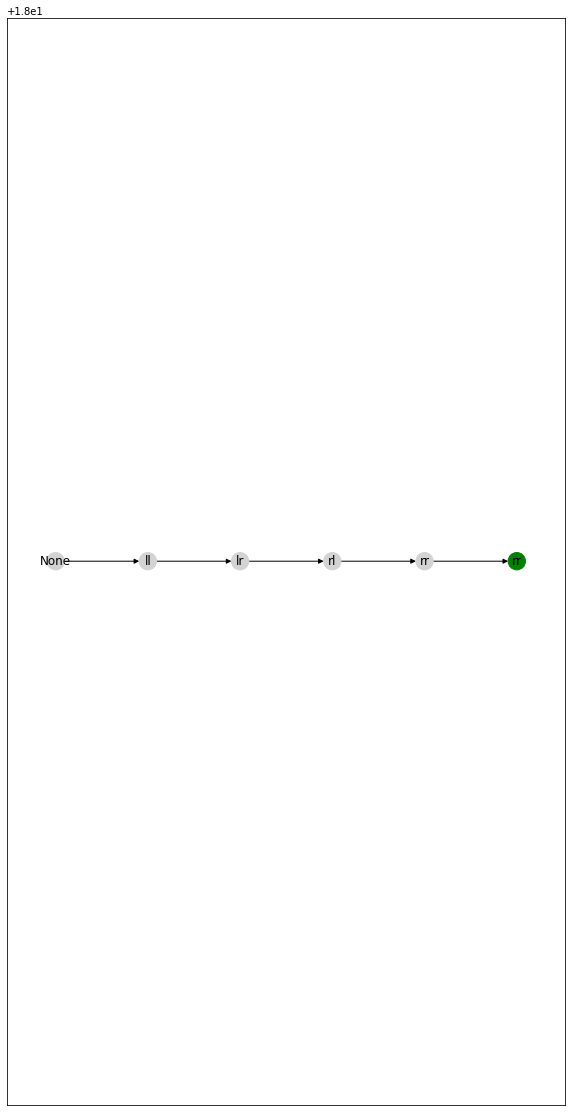

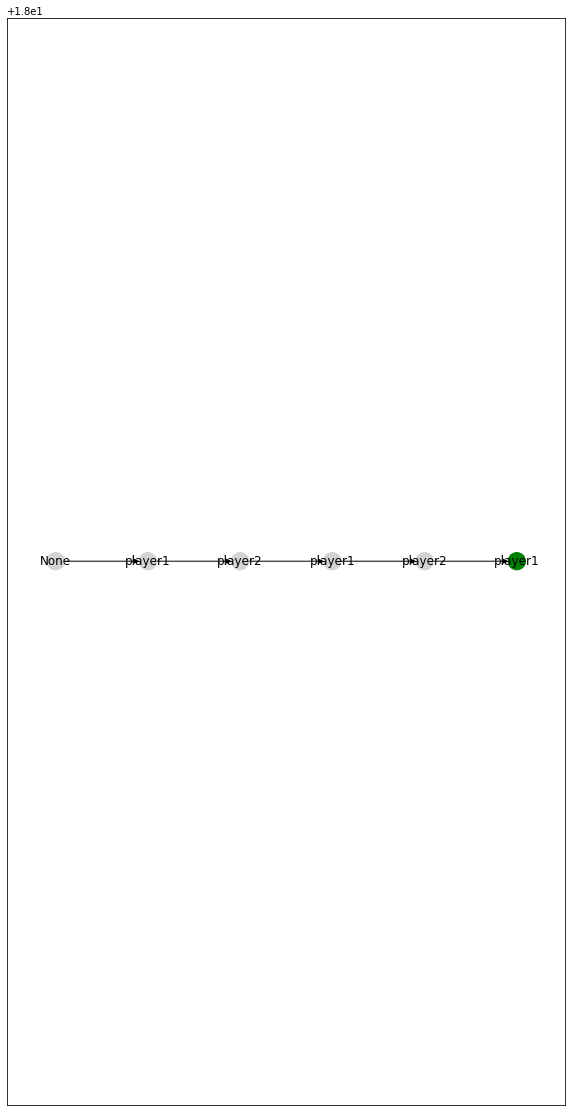

In [59]:
moves = ['ll', 'lr', 'rl', 'rr', 'rr']
game = Game(Player('player1'), Player('player2'))
result = game.check_moves(moves)
print(game.winner, [m.attack for m in game.moves])

if not result:
    print('illegal game!')
    del game

ai = AI(game, 4)
G, root = ai.eval_game_tree()
draw(G, 'attack')
draw(G, 'player')

In [60]:
###

None ['ll', 'lr', 'rl', 'rr']


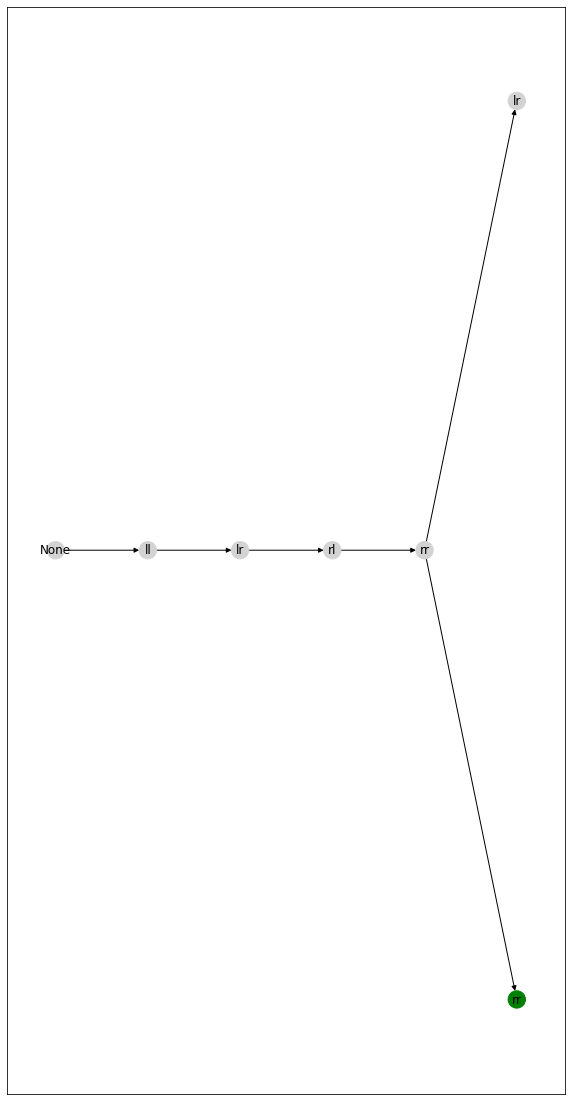

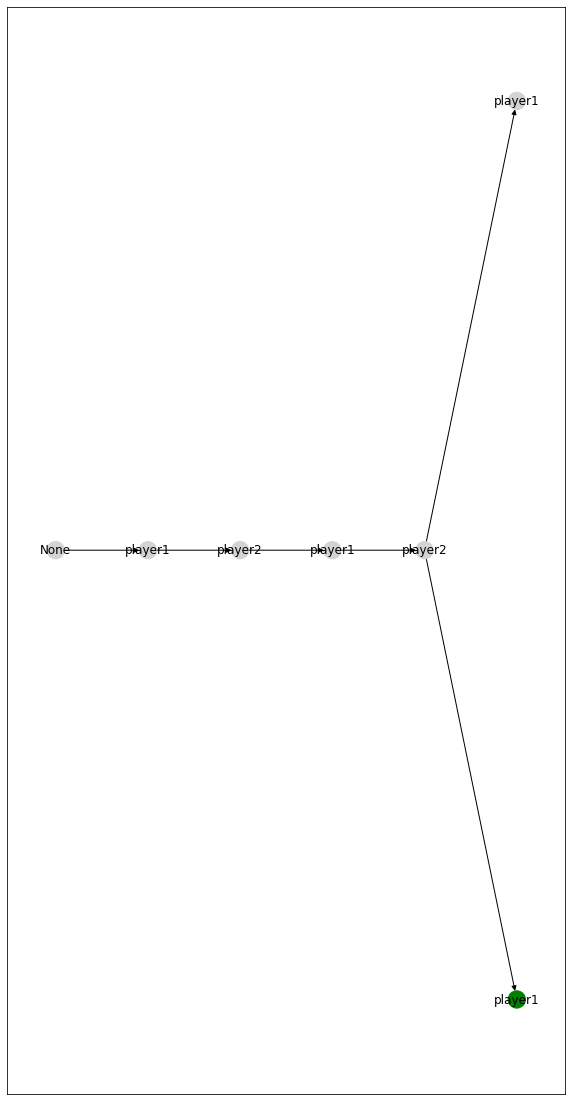

In [61]:
# one less move than win for player1 - player1 plays 'rr' to win
moves = ['ll', 'lr', 'rl', 'rr']
game = Game(Player('player1'), Player('player2'))
result = game.check_moves(moves)
print(game.winner, [m.attack for m in game.moves])

if not result:
    print('illegal game!')
    del game

ai = AI(game, 1)
G, root = ai.eval_game_tree()
draw(G, 'attack')
draw(G, 'player')

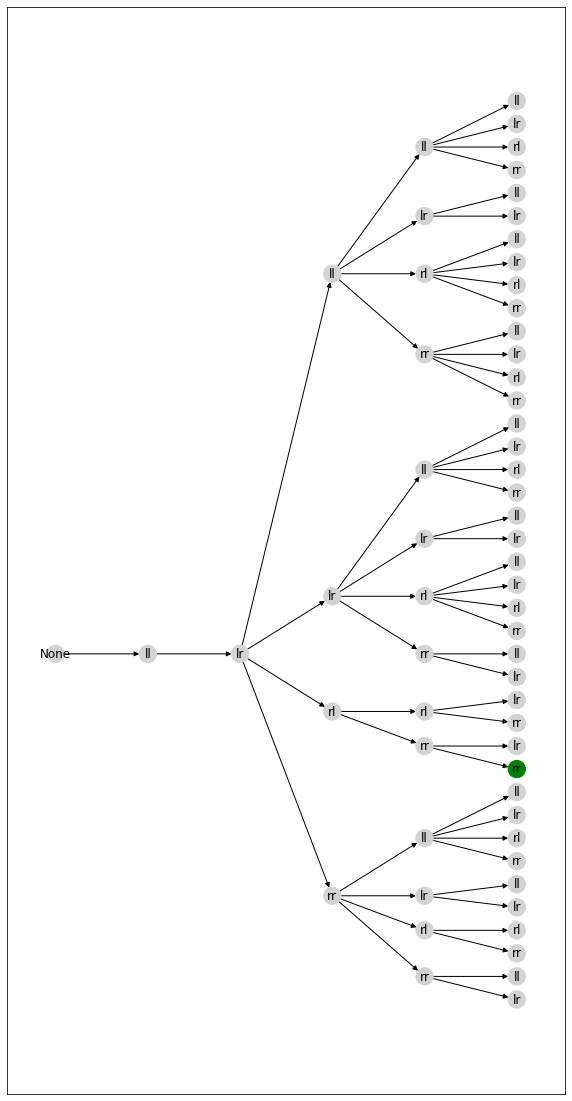

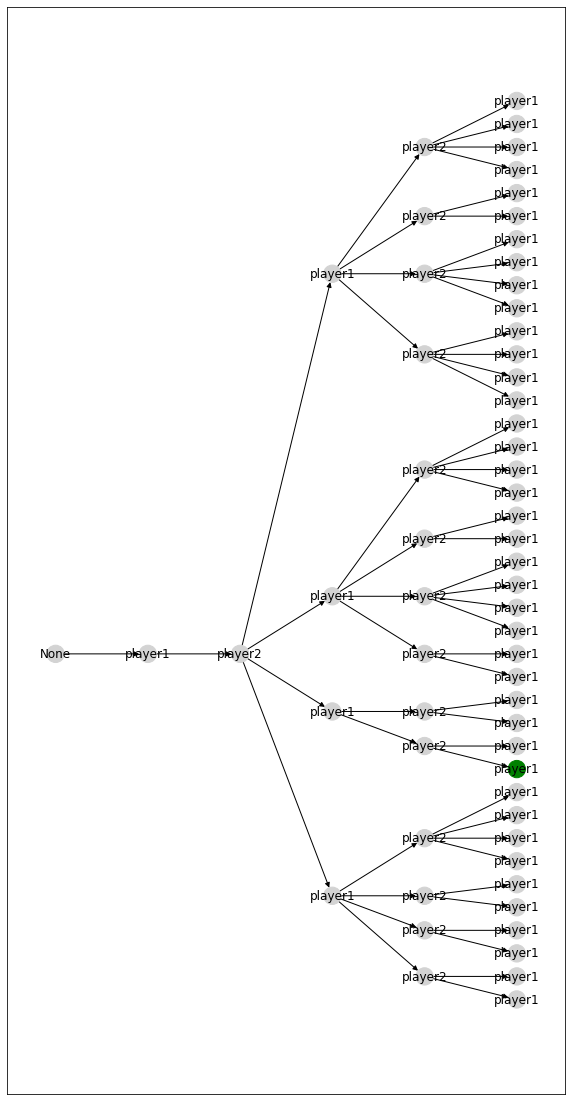

In [62]:
moves = ['ll', 'lr']
game = Game(Player('player1'), Player('player2'))
result = game.check_moves(moves)

if not result:
    print('illegal game!')
    del game

ai = AI(game, 3)
G, root = ai.eval_game_tree()
draw(G, 'attack')
draw(G, 'player')

In [63]:
## Now do minimax

In [64]:
assert game.active.name == 'player1'
best_move = ai.minimax(G, root)
print(best_move)

3


In [65]:
print(root)

2


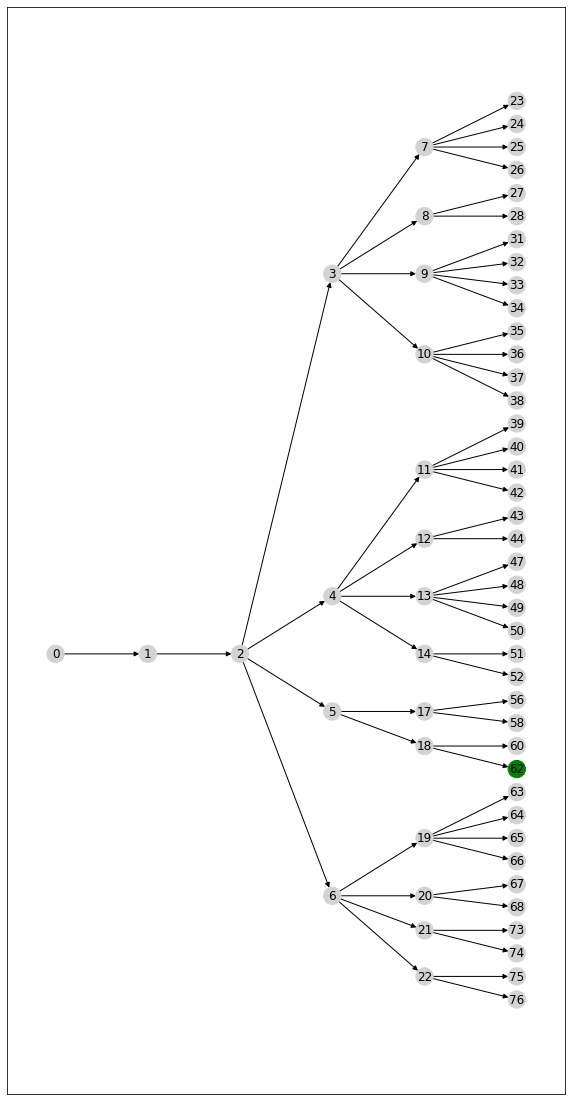

In [66]:
draw(G)

In [67]:
#### Do ALL moves

In [83]:
%%time
game = Game(Player('player1'), Player('player2'))
ai = AI(game, 12)
G, root = ai.eval_game_tree()

CPU times: user 3.3 s, sys: 7.29 ms, total: 3.31 s
Wall time: 3.31 s


In [84]:
G.number_of_nodes()

15933

In [72]:
#15933

In [77]:
nx.dag_longest_path_length(G)

12

In [85]:
[G.nodes[n] for n in nx.dag_longest_path(G)]

[{'attack': None, 'winner': None, 'player': None},
 {'attack': 'rr', 'winner': None, 'player': 'player1'},
 {'attack': 'lr', 'winner': None, 'player': 'player2'},
 {'attack': 'lr', 'winner': None, 'player': 'player1'},
 {'attack': 'lr', 'winner': None, 'player': 'player2'},
 {'attack': 'lr', 'winner': None, 'player': 'player1'},
 {'attack': 'lr', 'winner': None, 'player': 'player2'},
 {'attack': 'll', 'winner': None, 'player': 'player1'},
 {'attack': 'rr', 'winner': None, 'player': 'player2'},
 {'attack': 'll', 'winner': None, 'player': 'player1'},
 {'attack': 'll', 'winner': None, 'player': 'player2'},
 {'attack': 'lr', 'winner': None, 'player': 'player1'},
 {'attack': 'll', 'winner': 'player2', 'player': 'player2'}]

In [90]:
from collections import Counter

In [91]:
Counter([G.nodes[n]['winner'] for n in G.nodes if G.nodes[n]['winner']])

Counter({'player1': 3088, 'player2': 2784})